# Unified View Modelling
**Author:** Marang Mutloatse

**Description:** This script performs modelling on the UV

**Version:** 0.0.1

**Status:** Development

## Import Libraries

In [3]:
import os
user_dev_path = os.path.dirname(os.getcwd())
# get parent path for package
package_path = os.path.dirname(user_dev_path)
import sys
import pandas as pd
import yaml
import datetime as dt
import warnings
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import math
import glob
sys.path.insert(0,package_path + '/src/')
#from supervised_modelling import model_validation
from hiv_support_package import visit_features,helper_functions,evaluation_metrics,model_validation
from sklearn.impute import SimpleImputer
from datetime import timedelta, date
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.naive_bayes import *
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier,RidgeClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier, VotingClassifier
import pandas as pd
from copy import copy, deepcopy
from tqdm import tnrange, tqdm_notebook, tqdm
from sklearn.preprocessing import *
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold,TimeSeriesSplit,GridSearchCV
from numpy import mean
from numpy import std
import sklearn
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import LabelEncoder

plt.style.use('fivethirtyeight')
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

## Working Functions


In [4]:
def classification():
    roc_auc = []
    precision = []
    recall = []
    f1 =[]
    gini_coef = []
    ks_stat = []
    mcc = []
    sensitivity = []
    specificity = []
    pr_auc = []
    brier_loss = []
    
    for i in range(len(algorithms)):
        algorithms[i].fit(X_train, y_train) 
    for i in range(len(algorithms)):
        roc_auc.append(roc_auc_score(y_test, algorithms[i].predict_proba(X_test)[:,1]))
        precision.append(precision_score(y_test, algorithms[i].predict(X_test), average = 'macro'))
        recall.append(recall_score(y_test, algorithms[i].predict(X_test), average = 'macro'))
        f1.append(f1_score(y_test, algorithms[i].predict(X_test), average = 'macro'))
        gini_coef.append(evaluation_metrics.calculate_gini_score(y_test, algorithms[i].predict_proba(X_test)[:,1]))
        ks_stat.append(evaluation_metrics.calculate_ks(y_test,algorithms[i].predict_proba(X_test)[:,1]))
        mcc.append(matthews_corrcoef(y_test, algorithms[i].predict(X_test)))
        (tn, fp), (fn, tp) = confusion_matrix(y_test, algorithms[i].predict(X_test))
        specificity.append(round(tn/(tn+fp), 3))
        sensitivity.append(round(tp/(tp+fn),3))
        pr_auc.append(round(average_precision_score(y_test, algorithms[i].predict(X_test)), 3))
        brier_loss.append(brier_score_loss(y_test,algorithms[i].predict_proba(X_test)[:,1]))

    
    df_metrics = pd.DataFrame(columns = ['ROC_AUC','F1','Precision', 'Recall','MCC','GINI','KS','Sensitivity','Specificity','PR_AUC','Brier_Loss'], index = algo_names)
    df_metrics['ROC_AUC'] = roc_auc
    df_metrics['F1'] = f1
    df_metrics['Precision'] = precision
    df_metrics['Recall'] = recall
    df_metrics['MCC'] = mcc
    df_metrics['GINI'] = gini_coef
    df_metrics['KS'] = ks_stat
    df_metrics['Sensitivity'] = sensitivity
    df_metrics['Specificity'] = specificity
    df_metrics['PR_AUC'] = pr_auc
    df_metrics['Brier_Loss'] = brier_loss

    return df_metrics

Classification_results = {}
Final_Scores = pd.DataFrame(columns=['Model', 'Train_ROC','Test_ROC'])

def cv_classification(X_train, X_test, y_train, y_test, estimator, verbose=False ,Report=False):
    train_scores=[]
    test_scores=[]

    estimator.fit(X_train, y_train)
    #cv = TimeSeriesSplit(n_splits=4)
    cv = StratifiedKFold(n_splits=5, shuffle=True,random_state=42)
    train_metric = cross_val_score(estimator, X_train, y_train, scoring='roc_auc', cv=cv)
    train_scores.append(np.mean(train_metric))
    if verbose is True:
        print('Avg roc_auc: {:.3f} +/-{:.3f}'.format(np.mean(train_metric), np.std(train_metric)))
      
    y_pred = estimator.predict(X_test)
    test_score = estimator.score(X_test, y_test)
    test_scores.append(test_score)
   
    if verbose is True:
        print('roc_auc on test: {:.3f}'.format(test_score))
    if Report is True:
        print(classification_report(y_test,y_pred))
    
    return train_scores, test_scores

def plot_compare(d, label, new_training_score, new_test_score, ymin=0.1, ymax=0.99):
    d.update({label: [np.median(new_training_score),
                      np.median(new_test_score)]})
    plt.figure(figsize=(8,10))
    pd.DataFrame(d).set_index([pd.Index(['Training', 'Test'])]).plot.bar()
    plt.ylim(ymin, ymax)
    plt.savefig(f"../Figures/Predict_ROC_AUC_{label}.png",transparent=True,bbox_inches="tight")
    plt.show()

def features_importance(tree, X):
    importances = tree.feature_importances_
    indices = np.argsort(importances)

    plt.figure(figsize=(20, 10))
    plt.title("Feature importances")
    plt.barh(range(X_train.shape[1]), importances[indices],
             color="r", align="center")
    index_names = [list(X_train)[i] for i in indices]
    plt.yticks(range(X_train.shape[1]), index_names)
    plt.ylim([-1, X_train.shape[1]])
    plt.xlim([0.0, 0.8])
    plt.savefig(f"../Figures/featureImportance_{tree}.png",transparent=True,bbox_inches="tight")
    plt.show()

## Loading Data

In [9]:
try: 
    with open (user_dev_path + '/' + 'config_LTFU.yaml', 'r') as file:
        config = yaml.safe_load(file)
except Exception as e:
    print(f'Error reading the config file, {e}')

In [10]:
input_root = config['rise_files']['raw_data_path']
uv_file = config['output_files']['unified_view_file']
start_date_iit = config['iit_inclusion_criteria']['iit_start_date']
last_date_iit = config['iit_inclusion_criteria']['iit_last_date']
uv_input = input_root + uv_file
print(uv_input)
print(start_date_iit)
print(last_date_iit)

/data/rise_data/unified_view.csv
2017-01-01 00:00:00
2021-05-31 00:00:00


In [5]:
%%time
df = pd.read_csv(uv_input,low_memory=False)

CPU times: user 34.2 s, sys: 2.17 s, total: 36.4 s
Wall time: 36.4 s


## Initial Checks

In [6]:
helper_functions.print_num_rows_cols(df, 'Unified View')

Unified View data has 341 columns and 606136 rows.


In [7]:
pd.set_option('max_rows',None)
helper_functions.check_null_values(df)

There are 143 columns that have missing values


Missing Values  \
P_DATE_REGISTRATION                                         606136   
O_EF_DAYS_SINCE_FIRST_OTZ                                   598097   
O_DATE                                                      598097   
O_PATIENT_ID                                                598097   
O_EF_FIRST_DATE_OTZ                                         573290   
E_DATE                                                      573076   
E_PATIENT_ID                                                573076   
E_EF_OTZ_STARTED                                            527191   
E_EF_FIRST_DATE_EAC                                         507749   
L_T_VL_UNDETECT_40                                          351786   
L_EF_DAY_OF_WEEK_DATE_REPORTED                              351786   
L_EF_IS_WEEKEND_DATE_REPORTED                               351786   
L_EF_WEEK_OF_MONTH_DATE_REPORTED                            351786   
L_EF_QUARTER_DATE_REPORTED                                  351786   
L_EF_IS_START_OF_QUARTER_DATE_REPORTED                      351786   
L_EF_IS_END_OF_QUARTER_DATE_REPORTED                        351786   
L_EF_SEASON_DATE_REPORTED                                   351786   
L_T_VL_UNSUPP_1000                                          351786   
L_T_RISE_VL_CATEGORIZATION                                  351786   
L_T_VL_SUPP_1000                                            351786   
L_T_VL_SUPP_400                                             351786   
L_EF_IS_END_OF_MONTH_DATE_REPORTED                          351786   
L_T_VL_UNSUPP_400                                           351786   
L_EF_VL_COUNT                                               351786   
L_EF_LAST_VL_VALUE                                          351786   
L_EF_DAY_OF_MONTH_DATE_REPORTED                             351786   
L_RESULTAB                                                  351786   
L_EF_IS_START_OF_MONTH_DATE_REPORTED                        351786   
L_DATE_REPORTED                                             351786   
L_EF_VL_CUMMIN                                              351786   
L_EF_MONTH_DATE_REPORTED                                    351786   
L_PATIENT_ID                                                351786   
L_FACILITY_ID                                               351786   
L_LABORATORY_ID                                             351786   
L_DATE_COLLECTED                                            351786   
L_EF_VL_CUMMAX                                              351786   
L_COMMENT                                                   351786   
L_EF_YEAR_DATE_REPORTED                                     351786   
L_EF_VL_VAL                                                 351786   
C_BP                                                        292734   
C_EF_NEXT_ACTUAL_VISIT_DATE                                 190373   
C_EF_DAYS_BETWEEN_NEXT_APPOINTMENT_AND_ACTUAL_V...          190373   
C_T_DAYS_UNTIL_ACTUAL_VISIT_DATE                            190373   
P_DATE_CONFIRMED_HIV                                        139063   
V_EF_DAYS_BETWEEN_NEXT_APPOINTMENT_AND_ACTUAL_V...           78945   
V_EF_NEXT_ACTUAL_VISIT_DATE                                  78945   
V_EF_DAYS_BETWEEN_MEDS_CONSUMED_AND_ACTUAL_VISI...           78945   
V_T_DAYS_UNTIL_ACTUAL_VISIT_DATE                             78945   
C_ADHERENCE_LEVEL                                            35833   
C_EF_DAYS_SINCE_LAST_VISIT                                   30996   
C_T_IS_LAST_VISIT                                            30996   
C_T_NEXT_VISIT_FURTHER_THAN_60_DAYS                          30996   
C_T_MISSED_NEXT_VISIT_90                                     30996   
C_T_MISSED_NEXT_VISIT_60                                     30996   
C_T_MISSED_NEXT_VISIT_28                                     30996   
C_T_MISSED_NEXT_VISIT_7                                      30996   
C_EF_MONTHS_SINCE_FIRST_VISIT                                3

In [8]:
drop_some_cols = [
    "P_DATE_NEXT_CLINIC",
    "P_DATE_LAST_CLINIC",
    "V_PHARMACY_ID",
    "L_T_VL_SUPP_400",
    "L_T_VL_UNSUPP_400",
    "P_REGIMENTYPE",
    "L_LABORATORY_ID",
    "L_FACILITY_ID",
    "L_DATE_REPORTED",
    "L_DATE_COLLECTED",
    "P_PATIENT_ID",
    "P_DATE_NEXT_REFILL",
    "L_PATIENT_ID",
    "L_T_VL_UNSUPP_1000",
    "P_DATE_LAST_REFILL",
    "P_LAST_VIRAL_LOAD",
    "P_LAST_CD4",
    "P_LAST_CD4P",
    "P_REGIMEN",
    "P_DATE_CONFIRMED_HIV",
    "P_DATE_STARTED",
    "P_DATE_REGISTRATION",
    "P_DATE_BIRTH",
    "L_T_VL_UNDETECT_40",
    "E_EF_OTZ_STARTED",
    "E_PATIENT_ID",
    "E_DATE",
    "E_EF_FIRST_DATE_EAC",
    "E_EF_OTZ_STARTED",
    "C_CD4",
    "C_CD4P",
    "C_TB_STATUS",
    "C_BP",
    "C_EF_FIRST_DATE_VISIT",
    "C_EF_ID_SEQUENCE",
    "C_EF_DIFFERENT_LAST_FACILIITY",
    "C_EF_LAST_FACILITY_ID",   
]
df.drop(columns=drop_some_cols,inplace=True)

In [9]:
df = df.sort_values(by=['V_PATIENT_ID','V_DATE_VISIT'])

### Inclusion Criteria

In [10]:
# Filter date

df = df.loc[(df['EF_START_DATE_TREATMENT'] >= start_date_iit) & (df['V_DATE_VISIT'] <= last_date_iit)]

In [11]:
helper_functions.print_num_rows_cols(df, 'Unified View')

Unified View data has 305 columns and 303186 rows.


In [12]:
# Filter out for records that only have one occurrence
df = df[df['V_PATIENT_ID'].map(df['V_PATIENT_ID'].value_counts() > 1)]

In [13]:
helper_functions.print_num_rows_cols(df, 'Unified View')

Unified View data has 305 columns and 294540 rows.


In [14]:
current_status_list = [
"Known Death",
"Hiv+ Non Art",
"Hiv Exposed Status Unknown",
"Hiv Exposed Infant Status Unknown",
"Pre-Art Transfer Out",
"Hiv Exposed Infant Status Unknown","Died"]

In [15]:
df = df[~df['P_CURRENT_STATUS'].isin(current_status_list)]
df['S_CURRENT_STATUS'] = df['S_CURRENT_STATUS'].fillna("Art Start")
df['S_CURRENT_STATUS'] = df['S_CURRENT_STATUS'].str.title()
df['S_CURRENT_STATUS'] = df['S_CURRENT_STATUS'].str.upper()
df['S_CURRENT_STATUS'] = df['S_CURRENT_STATUS'].str.replace(' ','_')

## UV encoding and binning

In [16]:
# Rounding Age and Time in treatment to closest digits
df['EF_AGE_AT_START'] = df['EF_AGE_AT_START'].astype(int)
df['EF_AGE_AT_VISIT'] = df['EF_AGE_AT_VISIT'].astype(int)
df['EF_TIME_IN_TREATMENT_MONTHS'] = round(df['EF_TIME_IN_TREATMENT_MONTHS'],2)

In [17]:
df['U_EF_FIRST_DATE_VISIT'] = df.groupby('V_PATIENT_ID')['V_DATE_VISIT'].transform('min')
df['U_EF_FIRST_DATE_VISIT'] = pd.to_datetime(df['U_EF_FIRST_DATE_VISIT'])
df['V_DATE_VISIT'] = pd.to_datetime(df['V_DATE_VISIT'])
df['U_EF_MONTHS_SINCE_FIRST_VISIT'] = ((df['V_DATE_VISIT'] - df['U_EF_FIRST_DATE_VISIT'])/np.timedelta64(1, 'M'))
df['U_EF_MONTHS_SINCE_FIRST_VISIT'] = df['U_EF_MONTHS_SINCE_FIRST_VISIT'].fillna(0).astype(int)

In [18]:
df['U_EF_NUM_MISSED_MONTHS'] = df['U_EF_MONTHS_SINCE_FIRST_VISIT'] + 1 - df[['V_PATIENT_ID','V_DATE_VISIT']].groupby('V_PATIENT_ID').cumcount()
df['EF_V_DURATION_CAT'] = pd.cut(df['V_DURATION'],bins = [0,30,60,90,180,1800],labels=['(0-30)DAYS','(30-60)DAYS','(2-3)MONTHS','(3-6)MONTHS','(>6)MONTHS'],include_lowest=True)
df['P_EF_CURRENT_AGE_CAT'] = pd.cut(df['P_EF_CURRENT_AGE'],bins = [0,9,14,29,45,100],labels=['CHILD','TEEN','YOUNG-ADULT','MIDDLE-AGED ADULT','MATURE-ADULT'],include_lowest=True)
df['EF_AGE_AT_VISIT_CAT'] = pd.cut(df['EF_AGE_AT_VISIT'],bins = [0,9,14,29,45,100],labels=['CHILD','TEEN','YOUNG-ADULT','MIDDLE-AGED ADULT','MATURE-ADULT'],include_lowest=True)
df['EF_TIME_IN_TREATMENT_MONTHS_CATEGORIES'] = pd.cut(df['EF_TIME_IN_TREATMENT_MONTHS'],bins = [0,3,6,12,24,60],labels=['0-3months','3-6months','6-12months','1-2years','>2years'],include_lowest=True)

In [19]:
lga_vals = df['P_EF_LGA_RESIDENCE'].value_counts(normalize=True).head(36).index.tolist()
df.loc[~df["P_EF_LGA_RESIDENCE"].isin(lga_vals), "P_EF_LGA_RESIDENCE"] = "Other"
df['U_EF_IS_LGA_FACILITY_RESIDENCE_SAME'] = np.where(df['V_L.G.A']==df['P_EF_LGA_RESIDENCE'], 
                                           1, 0)

## Encoding on Unified View

In [20]:
def one_hot_encode_col(df,dummies_col:str,prefix_entry:str):
    if df is not None:
        try:
            dummies = pd.get_dummies(df[dummies_col], prefix=prefix_entry,drop_first=False)
            df = df.join(dummies)
            return df
        except Exception as e:
            print(f"Exception on one hot encoding with error: {e}")
df = one_hot_encode_col(df,'EF_AGE_AT_VISIT_CAT','EF_AGE_AT_VISIT_')
df = one_hot_encode_col(df,'EF_V_DURATION_CAT','EF_DURATION_')
df = one_hot_encode_col(df,'EF_TIME_IN_TREATMENT_MONTHS_CATEGORIES','EF_TIME_TREATMENT_')
df = one_hot_encode_col(df,'S_CURRENT_STATUS','S_CURRENT_STATUS_')
# Encoding LGA residence
le = LabelEncoder()
df['P_EF_LGA_RESIDENCE'] = le.fit_transform(df['P_EF_LGA_RESIDENCE'])
df['V_L.G.A'] = le.fit_transform(df['V_L.G.A'])

### List columns

In [21]:
cols_labs = df.columns[df.columns.str.startswith('L_')].to_list()
cols_pharm =  df.columns[df.columns.str.startswith('V_')].to_list()
cols_patient = df.columns[df.columns.str.startswith('P_')].to_list()
cols_clinic = df.columns[df.columns.str.startswith('C_')].to_list()
cols_eac =  df.columns[df.columns.str.startswith('E_')].to_list()
cols_otz = df.columns[df.columns.str.startswith('O_')].to_list()

In [22]:
# fill na for labs
for col in cols_labs:
    df[col] = df[col].fillna(-1.0)

In [23]:
for col in cols_clinic:
    df[col] =  df[col].fillna(-1.0)

## Correlation Analysis

In [24]:
# Check correation
c = df.corr().abs()
s = c.unstack()
so = s.sort_values(kind="quicksort")

## Train-Test Split

In [25]:
# Get array of unique ids
df_copy = df.copy()
df_id = df_copy.drop_duplicates(subset='V_PATIENT_ID')
df_id = df_id[['V_PATIENT_ID']]
df_id.shape

(41394, 1)

In [26]:
# setting standardized random value 
np.random.seed(42)
df_id['random_chance'] = (np.random.randint(0, 45000, df_id.shape[0]))/45000
df_id=df_id[['V_PATIENT_ID', 'random_chance']]

In [27]:
# Splitting data by getting 64% of ids in train, 16% validation and 20% in test
df_id['MODELING_GROUP'] = np.where(((df_id.random_chance <= 0.64)), 'TRAINING', np.where(((df_id.random_chance <= 0.80)), 'VALIDATION', 'TESTING'))
df_id.groupby(['MODELING_GROUP'])['random_chance'].count()

MODELING_GROUP
TESTING        8025
TRAINING      26950
VALIDATION     6419
Name: random_chance, dtype: int64

In [28]:
df = df.sort_values(by=['V_PATIENT_ID'],ascending=True)
df_id = df_id.sort_values(by=['V_PATIENT_ID'],ascending=True)
df = df.merge(df_id, on=['V_PATIENT_ID'], how='inner')

# Show number of records in each group
df.groupby(['MODELING_GROUP'])['random_chance'].count()

MODELING_GROUP
TESTING        51283
TRAINING      173606
VALIDATION     41631
Name: random_chance, dtype: int64

In [29]:
# Split into train test and validation
train = df[df['MODELING_GROUP'] == 'TRAINING']
test = df[df['MODELING_GROUP'] == 'TESTING']
val = df[df['MODELING_GROUP'] == 'VALIDATION']

In [30]:
train_in_test = train.assign(In_test=train.V_PATIENT_ID.isin(test.V_PATIENT_ID).astype(int))
test_in_val = test.assign(In_val=test.V_PATIENT_ID.isin(val.V_PATIENT_ID).astype(int))
train_in_val = train.assign(In_val=train.V_PATIENT_ID.isin(val.V_PATIENT_ID).astype(int))

In [31]:
train_in_test['In_test'].value_counts()

0    173606
Name: In_test, dtype: int64

In [32]:
test_in_val['In_val'].value_counts()

0    51283
Name: In_val, dtype: int64

### Demographic Checks

In [33]:
train.V_PATIENT_ID.nunique()
round(100*train['P_EF_IS_MALE'].value_counts(normalize=True),2)

0.0    67.72
1.0    32.28
Name: P_EF_IS_MALE, dtype: float64

In [34]:
test.V_PATIENT_ID.nunique()
round(100*test['P_EF_IS_MALE'].value_counts(normalize=True),2)

0.0    67.37
1.0    32.63
Name: P_EF_IS_MALE, dtype: float64

In [35]:
val.V_PATIENT_ID.nunique()
round(100*val['P_EF_IS_MALE'].value_counts(normalize=True),2)

0.0    68.0
1.0    32.0
Name: P_EF_IS_MALE, dtype: float64

### Data Target Balance Checks

In [36]:
train.V_T_MISSED_NEXT_VISIT_28_RISE.value_counts(normalize=True)

0    0.661348
1    0.338652
Name: V_T_MISSED_NEXT_VISIT_28_RISE, dtype: float64

In [37]:
test.V_T_MISSED_NEXT_VISIT_28_RISE.value_counts(normalize=True)

0    0.665016
1    0.334984
Name: V_T_MISSED_NEXT_VISIT_28_RISE, dtype: float64

In [38]:
val.V_T_MISSED_NEXT_VISIT_28_RISE.value_counts(normalize=True)

0    0.664649
1    0.335351
Name: V_T_MISSED_NEXT_VISIT_28_RISE, dtype: float64

In [39]:
# Sorting and Dropping Patient_ID
train = train.sort_values(by=["V_PATIENT_ID", "V_DATE_VISIT"])
train = train.drop(["V_DATE_VISIT", "V_PATIENT_ID"], axis=1)
test = test.sort_values(by=["V_PATIENT_ID", "V_DATE_VISIT"])
test = test.drop(["V_DATE_VISIT", "V_PATIENT_ID"], axis=1)
val = val.sort_values(by=["V_PATIENT_ID", "V_DATE_VISIT"])
val = val.drop(["V_DATE_VISIT", "V_PATIENT_ID"], axis=1)

In [40]:
print("Number of observations in the training data:", len(train))
print("Number of observations in the test data:", len(test))
print("Number of observations in the validation data:", len(val))

Number of observations in the training data: 173606
Number of observations in the test data: 51283
Number of observations in the validation data: 41631


## Set Targets for train, test, val

In [41]:
X_train = train.drop(["V_T_MISSED_NEXT_VISIT_28_RISE"],axis=1)
y_train = train['V_T_MISSED_NEXT_VISIT_28_RISE']
X_test = test.drop(['V_T_MISSED_NEXT_VISIT_28_RISE'],axis=1)
y_test = test['V_T_MISSED_NEXT_VISIT_28_RISE']
X_val = val.drop(['V_T_MISSED_NEXT_VISIT_28_RISE'],axis=1)
y_val = val['V_T_MISSED_NEXT_VISIT_28_RISE']

# Baseline-Demographic Model

In [42]:
feature_set = [
    #"EF_AGE_AT_VISIT",
    "P_EF_CURRENT_AGE",
    "EF_TIME_IN_TREATMENT_MONTHS",
    #"EF_TIME_IN_TREATMENT_MONTHS_CATEGORIES",
    "V_EF_YEAR_DATE_VISIT",
    "V_EF_MONTH_DATE_VISIT",
#"V_EF_YEAR_EF_MEDS_CONSUMED_DATE",
#"V_EF_MONTH_EF_MEDS_CONSUMED_DATE",
 #"V_EF_ISSTARTOFMONTH_EF_MEDS_CONSUMED_DATE",
#  "V_EF_ISENDOFMONTH_EF_MEDS_CONSUMED_DATE",
 "V_EF_DAYOFMONTH_EF_MEDS_CONSUMED_DATE",
#     "V_FACILITY_ID",
    #"V_EF_DAYOFWEEK_EF_MEDS_CONSUMED_DATE",
 "V_EF_DAYOFWEEK_EF_MEDS_CONSUMED_DATE",
#  "V_EF_ISWEEKEND_EF_MEDS_CONSUMED_DATE",
 "V_EF_WEEKOFMONTH_EF_MEDS_CONSUMED_DATE",
#  "V_EF_QUARTER_EF_MEDS_CONSUMED_DATE",
#  'V_EF_ISSTARTOFQUARTER_EF_MEDS_CONSUMED_DATE",
 #'V_EF_ISENDOFQUARTER_EF_MEDS_CONSUMED_DATE',
#     "EF_DURATION__(0-30)DAYS",
#     "EF_DURATION__(30-60)DAYS",
#     "EF_DURATION__(2-3)MONTHS",
#     "EF_DURATION__(3-6)MONTHS",
#     "EF_TIME_TREATMENT__0-3months",
#     "EF_TIME_TREATMENT__3-6months",
#     "EF_TIME_TREATMENT__6-12months",
#     "EF_TIME_TREATMENT__1-2years",
#     "EF_AGE_AT_VISIT__MATURE-ADULT",
#     "EF_AGE_AT_VISIT__MIDDLE-AGED ADULT",
#     "EF_AGE_AT_VISIT__YOUNG-ADULT",
#     "EF_AGE_AT_VISIT__CHILD",
#     "EF_AGE_AT_VISIT__TEEN",
#     "P_EDUCATION",
#     "P_OCCUPATION",
    "P_EF_LGA_RESIDENCE",
    "U_EF_IS_LGA_FACILITY_RESIDENCE_SAME",
#     "P_PREGNANT",
#     "P_BREASTFEEDING",
    "P_EF_IS_MALE",
#     "P_EF_MARITAL_STATUS_DIVORCED",
#     "P_EF_MARITAL_STATUS_MARRIED",
#     "P_EF_MARITAL_STATUS_SEPARATED",
#     "P_EF_MARITAL_STATUS_SINGLE",
#     "P_EF_MARITAL_STATUS_WIDOWED",
    "P_EF_STATE_RESIDENCE_ADAMAWA",
    "P_EF_STATE_RESIDENCE_AKWA_IBOM",
    "P_EF_STATE_RESIDENCE_CROSS_RIVER",
     "P_EF_STATE_RESIDENCE_NIGER",
    "V_EF_STATE_ADAMAWA",
    "V_EF_STATE_AKWA_IBOM",
    "V_EF_STATE_CROSS_RIVER",
#     "V_EF_REGIMEN_LINE_ART_FIRST_LINE_CHILDREN",
#     "V_EF_REGIMEN_LINE_ART_FIRST_LINE_ADULT",
#     "V_EF_REGIMEN_LINE_ART_SECOND_LINE_ADULT",
#     "V_EF_REGIMEN_LINE_ART_SECOND_LINE_CHILDREN",
#     'V_EF_REGIMEN_LINE_ID_1',
#      'V_EF_REGIMEN_LINE_ID_2',
#      'V_EF_REGIMEN_LINE_ID_3',
#      'V_EF_REGIMEN_LINE_ID_4',
#      'V_EF_REGIMEN_LINE_ID_8',
     "V_EF_VISITS_AT_THIS_FACILITY",
     #"V_EF_FACILITY_COMPOSITION",
     "V_EF_VISITS_ON_THIS_REGIMEN",
     #"V_EF_REGIMEN_COMPOSITION",
    #"P_CURRENT_STATUS",
    "V_EF_MORE_THAN_3_DAYS_LATE_COUNT_MEDS",
    #"V_EF_MORE_THAN_3_DAYS_LATE_RATIO_MEDS",
    #"V_EF_MORE_THAN_28_DAYS_LATE_COUNT_MEDS",
    #"V_EF_MORE_THAN_28_DAYS_LATE_RATIO_MEDS",
    #"V_EF_MORE_THAN_60_DAYS_LATE_COUNT_MEDS",
    #"V_EF_MORE_THAN_60_DAYS_LATE_RATIO_MEDS",
    #"V_EF_MORE_THAN_90_DAYS_LATE_COUNT_MEDS",
    #"V_EF_MORE_THAN_90_DAYS_LATE_RATIO_MEDS",
#     "V_EF_WAS_MORE_THAN_3_DAYS_LATE",
#      "V_EF_WAS_MORE_THAN_28_DAYS_LATE",
#      "V_EF_WAS_MORE_THAN_60_DAYS_LATE",
#      "V_EF_WAS_MORE_THAN_90_DAYS_LATE",
    "V_EF_DAYS_LATE_MEDS",
#     "V_EF_DIFFERENT_LAST_FACILIITY",
#     "U_EF_NUM_MISSED_MONTHS",
    "V_EF_LATE_THIS_VISIT_MEDS",
    "V_EF_LATE_LAST_VISIT_MEDS",
    "V_DURATION",
"L_T_RISE_VL_CATEGORIZATION",
"L_T_VL_SUPP_1000",
# "L_EF_VL_COUNT",
# "L_EF_LAST_VL_VALUE",
    #"L_EF_VL_VAL",
#"L_EF_VL_CUMMAX",
     #"L_EF_VL_CUMMIN",
"L_COMMENT",
   # "V_EF_REGIMEN_COMPOSITION",
#"V_EF_DAYS_SINCE_LAST_VISIT",
    "V_EF_MONTHS_SINCE_LAST_VISIT",
    #"U_EF_MONTHS_SINCE_FIRST_VISIT",
#      'C_CLINIC_STAGE',
#  'C_FUNC_STATUS',
    #'C_BODY_WEIGHT',
#      'C_PREGNANT',
#  'C_BREASTFEEDING',
#  'C_OI_SCREENED',
#  'C_ADR_SCREENED',
 'C_ADHERENCE_LEVEL',
#  'C_COMMENCE',
'C_STAGE_WORSENED',
#  'C_WEIGHT_LOSS',
#  'C_EF_DAYS_UNTIL_NEXT_APPOINTMENT',
#  'C_EF_YEAR_DATE_VISIT',
#  'C_EF_MONTH_DATE_VISIT',
#  'C_EF_ISSTARTOFMONTH_DATE_VISIT',
#  'C_EF_ISENDOFMONTH_DATE_VISIT',
#  'C_EF_DAYOFMONTH_DATE_VISIT',
#  'C_EF_DAYOFWEEK_DATE_VISIT',
#  'C_EF_ISWEEKEND_DATE_VISIT',
 'C_EF_WEEKOFMONTH_DATE_VISIT',
#  'C_EF_QUARTER_DATE_VISIT',
#  'C_EF_ISSTARTOFQUARTER_DATE_VISIT',
#  'C_EF_ISENDOFQUARTER_DATE_VISIT',
#  'C_EF_SEASON_DATE_VISIT',
#  'C_EF_ISSTARTOFMONTH_NEXT_APPOINTMENT',
#  'C_EF_ISENDOFMONTH_NEXT_APPOINTMENT',
 'C_EF_DAYOFMONTH_NEXT_APPOINTMENT',
#  'C_EF_DAYOFWEEK_NEXT_APPOINTMENT',
# 'C_EF_ISWEEKEND_NEXT_APPOINTMENT',
 'C_EF_WEEKOFMONTH_NEXT_APPOINTMENT',
#  'C_EF_QUARTER_NEXT_APPOINTMENT',
#  'C_EF_ISSTARTOFQUARTER_NEXT_APPOINTMENT',
 'C_EF_ISENDOFQUARTER_NEXT_APPOINTMENT',
#  'C_EF_SEASON_NEXT_APPOINTMENT',
#  'C_EF_LAST_VISIT_DATE',
 'C_EF_DAYS_SINCE_LAST_VISIT',
#  'C_EF_MONTHS_SINCE_LAST_VISIT',
 'C_EF_MONTHS_SINCE_FIRST_VISIT',
 #'C_EF_NEXT_ACTUAL_VISIT_DATE',
 #'C_EF_DAYS_BETWEEN_NEXT_APPOINTMENT_AND_ACTUAL_VISIT_DATE',
#  'C_T_MISSED_NEXT_VISIT_7',
#  'C_T_MISSED_NEXT_VISIT_28',
#  'C_T_MISSED_NEXT_VISIT_60',
#  'C_T_MISSED_NEXT_VISIT_90',
#  'C_T_IS_LAST_VISIT',
 'C_EF_DAYS_LATE',
#  'C_EF_WAS_MORE_THAN_3_DAYS_LATE',
#  'C_EF_WAS_MORE_THAN_28_DAYS_LATE',
 'C_EF_WAS_MORE_THAN_60_DAYS_LATE',
#  'C_EF_WAS_MORE_THAN_90_DAYS_LATE',
 'C_EF_LATE_THIS_VISIT',
 'C_EF_LATE_LAST_VISIT',
# 'C_EF_MORE_THAN_3_DAYS_LATE_COUNT',
#  'C_EF_MORE_THAN_3_DAYS_LATE_RATIO',
  'C_EF_MORE_THAN_28_DAYS_LATE_COUNT',
#  'C_EF_MORE_THAN_28_DAYS_LATE_RATIO',
# 'C_EF_MORE_THAN_60_DAYS_LATE_COUNT',
#  'C_EF_MORE_THAN_60_DAYS_LATE_RATIO',
#  'C_EF_MORE_THAN_90_DAYS_LATE_COUNT',
#  'C_EF_MORE_THAN_90_DAYS_LATE_RATIO',
#  'E_EAC_COUNT',
#  'E_EF_MONTHS_SINCE_FIRST_EAC',
 'E_EF_EAC_STARTED',
#  'E_DAYS_SINCE_LAST_EAC_AT_ARV_PICKUP',
#  'E_MONTHS_SINCE_LAST_EAC_AT_ARV_PICKUP',
#  'V_REGIMEN_LINE_CHANGE',
'STATUS_CHANGE']# 'S_CURRENT_STATUS__ART_RESTART',
# 'S_CURRENT_STATUS__ART_START']
# #  'S_CURRENT_STATUS__ART_START_-_EXTERNAL',
#  'S_CURRENT_STATUS__ART_TRANSFER_IN',
#  'S_CURRENT_STATUS__ART_TRANSFER_OUT',
#  'S_CURRENT_STATUS__LOST_TO_FOLLOW_UP',
#  'S_CURRENT_STATUS__PRE-ART_TRANSFER_IN',
#  'S_CURRENT_STATUS__PRE-ART_TRANSFER_OUT',
#  'S_CURRENT_STATUS__STOPPED_TREATMENT']

In [43]:
len(feature_set)

43

In [44]:
X_train = X_train[feature_set]
X_test = X_test[feature_set]
X_val = X_val[feature_set]

## Scaling Data

In [45]:
ss = MinMaxScaler()
ssR = RobustScaler()
features_to_scale = [
    #"L_T_RISE_VL_CATEGORIZATION",
    #"L_T_VL_SUPP_1000",
#     "L_EF_VL_COUNT",
#     "L_EF_LAST_VL_VALUE",
#     "L_EF_VL_VAL",
#     "L_EF_VL_CUMMAX",
#     "L_EF_VL_CUMMIN",
    #"V_EF_DAYS_LATE_MEDS",
   # "L_COMMENT",
#     "U_EF_NUM_MISSED_MONTHS",
   "EF_TIME_IN_TREATMENT_MONTHS",
    "V_EF_MORE_THAN_3_DAYS_LATE_COUNT_MEDS",
    #"V_EF_MORE_THAN_3_DAYS_LATE_RATIO_MEDS",
    #"V_EF_MORE_THAN_28_DAYS_LATE_COUNT_MEDS",
    "V_EF_MONTHS_SINCE_LAST_VISIT",
#     "U_EF_MONTHS_SINCE_FIRST_VISIT",
    #"V_EF_MORE_THAN_28_DAYS_LATE_RATIO_MEDS",
    #"V_EF_MORE_THAN_60_DAYS_LATE_COUNT_MEDS",
    #"V_EF_MORE_THAN_60_DAYS_LATE_RATIO_MEDS",
    #"V_EF_MORE_THAN_90_DAYS_LATE_COUNT_MEDS",
    #"V_EF_MORE_THAN_90_DAYS_LATE_RATIO_MEDS",
#     "V_EF_WAS_MORE_THAN_3_DAYS_LATE",
#      "V_EF_WAS_MORE_THAN_28_DAYS_LATE",
#      "V_EF_WAS_MORE_THAN_60_DAYS_LATE",
#      "V_EF_WAS_MORE_THAN_90_DAYS_LATE",
    #"V_EF_DAYS_SINCE_LAST_VISIT",
    "C_EF_DAYS_LATE",
     #"C_EF_MORE_THAN_3_DAYS_LATE_COUNT",
#  'C_EF_MORE_THAN_3_DAYS_LATE_RATIO',
 "C_EF_MORE_THAN_28_DAYS_LATE_COUNT",
#  'C_EF_MORE_THAN_28_DAYS_LATE_RATIO',
 #"C_EF_MORE_THAN_60_DAYS_LATE_COUNT",
#  'C_EF_MORE_THAN_60_DAYS_LATE_RATIO',
#  "C_EF_MORE_THAN_90_DAYS_LATE_COUNT",
    "V_DURATION",
    "V_EF_VISITS_ON_THIS_REGIMEN","P_EF_CURRENT_AGE",
"V_EF_VISITS_ON_THIS_REGIMEN",
# # "EF_AGE_AT_VISIT",
   "C_EF_DAYS_SINCE_LAST_VISIT",
#  "C_EF_MONTHS_SINCE_LAST_VISIT",
    "C_EF_MONTHS_SINCE_FIRST_VISIT"]

In [46]:
X_train[features_to_scale] = ssR.fit_transform(X_train[features_to_scale])
X_test[features_to_scale] = ssR.transform(X_test[features_to_scale])
X_val[features_to_scale] = ssR.transform(X_val[features_to_scale])

In [47]:
X_val.columns

Index(['P_EF_CURRENT_AGE', 'EF_TIME_IN_TREATMENT_MONTHS',
       'V_EF_YEAR_DATE_VISIT', 'V_EF_MONTH_DATE_VISIT',
       'V_EF_DAYOFMONTH_EF_MEDS_CONSUMED_DATE',
       'V_EF_DAYOFWEEK_EF_MEDS_CONSUMED_DATE',
       'V_EF_WEEKOFMONTH_EF_MEDS_CONSUMED_DATE', 'P_EF_LGA_RESIDENCE',
       'U_EF_IS_LGA_FACILITY_RESIDENCE_SAME', 'P_EF_IS_MALE',
       'P_EF_STATE_RESIDENCE_ADAMAWA', 'P_EF_STATE_RESIDENCE_AKWA_IBOM',
       'P_EF_STATE_RESIDENCE_CROSS_RIVER', 'P_EF_STATE_RESIDENCE_NIGER',
       'V_EF_STATE_ADAMAWA', 'V_EF_STATE_AKWA_IBOM', 'V_EF_STATE_CROSS_RIVER',
       'V_EF_VISITS_AT_THIS_FACILITY', 'V_EF_VISITS_ON_THIS_REGIMEN',
       'V_EF_MORE_THAN_3_DAYS_LATE_COUNT_MEDS', 'V_EF_DAYS_LATE_MEDS',
       'V_EF_LATE_THIS_VISIT_MEDS', 'V_EF_LATE_LAST_VISIT_MEDS', 'V_DURATION',
       'L_T_RISE_VL_CATEGORIZATION', 'L_T_VL_SUPP_1000', 'L_COMMENT',
       'V_EF_MONTHS_SINCE_LAST_VISIT', 'C_ADHERENCE_LEVEL', 'C_STAGE_WORSENED',
       'C_EF_WEEKOFMONTH_DATE_VISIT', 'C_EF_DAYOFMONTH_NEXT_APP

### LogReg Model

Avg roc_auc: 0.783 +/-0.001
roc_auc on test: 0.749


<Figure size 576x720 with 0 Axes>

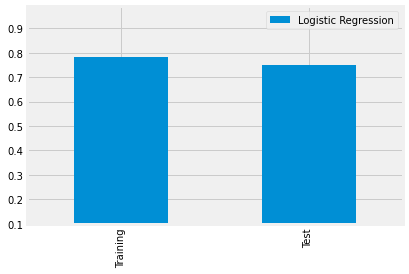

In [48]:
Simple_Tree = LogisticRegression(random_state=42,solver='liblinear',C=10,penalty='l2') 
cv_scores, test_scores = cv_classification(X_train, X_test, y_train, y_test,Simple_Tree,verbose=True)
plot_compare(Classification_results,'Logistic Regression',cv_scores,test_scores)
Final_Scores.loc[len(Final_Scores)+1] = ['Logisitic Regression', cv_scores, test_scores]

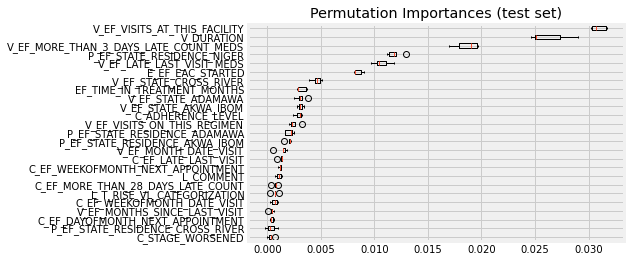

<Figure size 1440x1440 with 0 Axes>

In [49]:
result = permutation_importance(Simple_Tree, X_test, y_test, n_repeats=5,
                                    random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

end = len(sorted_idx)
start = 0
if end >25:
    start=end-25

    fig, ax = plt.subplots()
    plt.figure(figsize=(20,20))
    ax.boxplot(result.importances[sorted_idx[start:end]].T,
               vert=False, labels=X_test.columns[sorted_idx[start:end]])
    ax.set_title("Permutation Importances (test set)")
    plt.savefig(f"../Figures/Best_Importance_LogReg.png",transparent=True,bbox_inches="tight")
    plt.show()

Train set target distribution:
 114814 0.661348110088361 
 58792 0.338651889911639 

Test set target distribution:
 34104 0.67 
 17179 0.33 


Metrics:
  f1: 0.574
  MCC: 0.408
  accuracy: 0.749
  specificity: 0.872
  precision: 0.665
  recal: 0.505
  roc_auc: 0.783
  GINI: 0.565
  PR_AUC: 0.502
  Brier_loss: 0.173

Classification report:
               precision    recall  f1-score   support

           0       0.78      0.87      0.82     34104
           1       0.67      0.50      0.57     17179

    accuracy                           0.75     51283
   macro avg       0.72      0.69      0.70     51283
weighted avg       0.74      0.75      0.74     51283



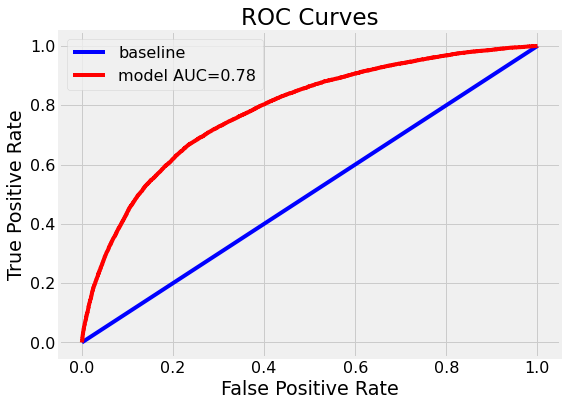

Confusion matrix:
[[29741  4363]
 [ 8508  8671]]


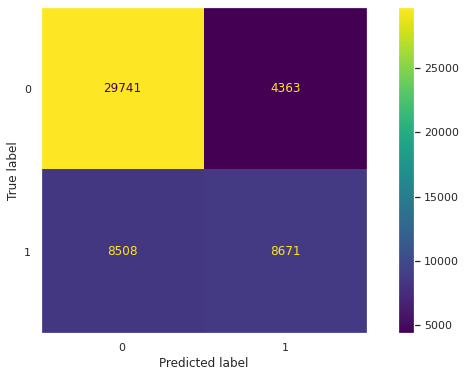

In [50]:
model_validation.evaluate_model(Simple_Tree, Simple_Tree.predict(X_test), Simple_Tree.predict_proba(X_test)[:,1], y_train, X_test, y_test, T_labels=None, normalise_conf_mtx=None)

### Random Forest Model

Avg roc_auc: 0.805 +/-0.001
roc_auc on test: 0.747


<Figure size 576x720 with 0 Axes>

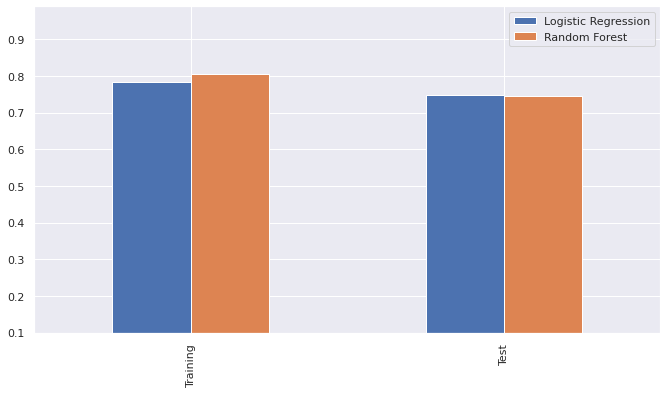

In [51]:
Random_Forest = RandomForestClassifier(random_state=42,n_estimators=300,criterion='gini',max_features='auto',min_samples_split=4,max_depth=6) 
cv_scores, test_scores = cv_classification(X_train, X_test, y_train, y_test,Random_Forest,verbose=True)
plot_compare(Classification_results,'Random Forest',cv_scores,test_scores)
Final_Scores.loc[len(Final_Scores)+1] = ['Random Forest', cv_scores, test_scores]

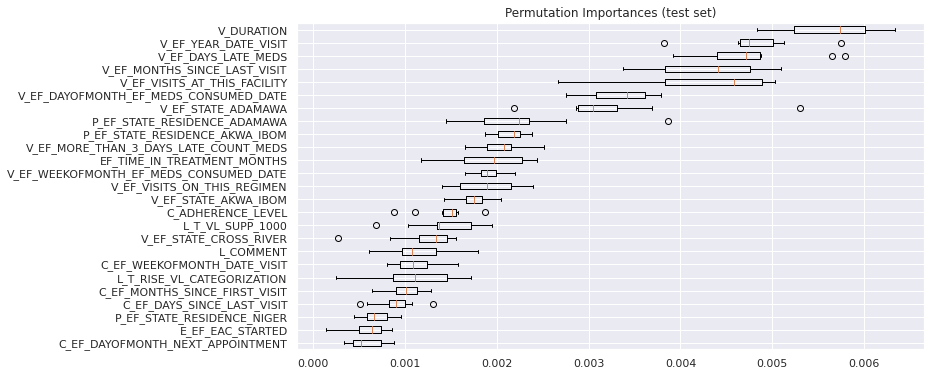

<Figure size 1440x1440 with 0 Axes>

In [52]:
from sklearn.inspection import permutation_importance
result = permutation_importance(Random_Forest, X_test, y_test, n_repeats=10,
                                    random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

end = len(sorted_idx)
start = 0
if end >25:
    start=end-25

    fig, ax = plt.subplots()
    plt.figure(figsize=(20,20))
    ax.boxplot(result.importances[sorted_idx[start:end]].T,
               vert=False, labels=X_test.columns[sorted_idx[start:end]])
    ax.set_title("Permutation Importances (test set)")
    plt.show()

Train set target distribution:
 114814 0.661348110088361 
 58792 0.338651889911639 

Test set target distribution:
 34104 0.67 
 17179 0.33 


Metrics:
  f1: 0.511
  MCC: 0.389
  accuracy: 0.747
  specificity: 0.924
  precision: 0.724
  recal: 0.395
  roc_auc: 0.806
  GINI: 0.612
  PR_AUC: 0.488
  Brier_loss: 0.168

Classification report:
               precision    recall  f1-score   support

           0       0.75      0.92      0.83     34104
           1       0.72      0.39      0.51     17179

    accuracy                           0.75     51283
   macro avg       0.74      0.66      0.67     51283
weighted avg       0.74      0.75      0.72     51283



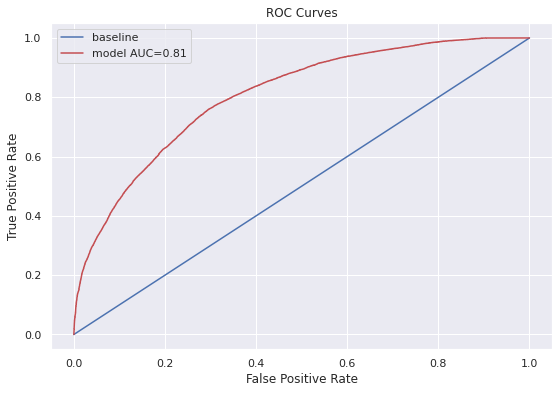

Confusion matrix:
[[31514  2590]
 [10397  6782]]


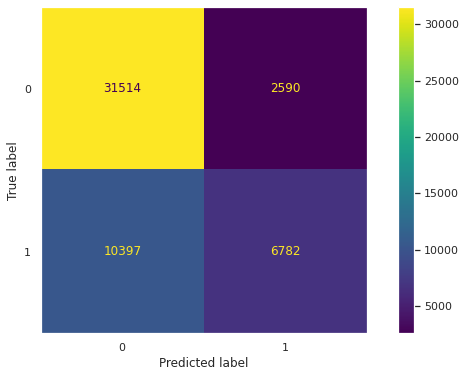

In [53]:
model_validation.evaluate_model(Random_Forest, Random_Forest.predict(X_test), Random_Forest.predict_proba(X_test)[:,1], y_train, X_test, y_test, T_labels=None, normalise_conf_mtx=None)

### Adaboost Classifier

Avg roc_auc: 0.762 +/-0.003
roc_auc on test: 0.733


<Figure size 576x720 with 0 Axes>

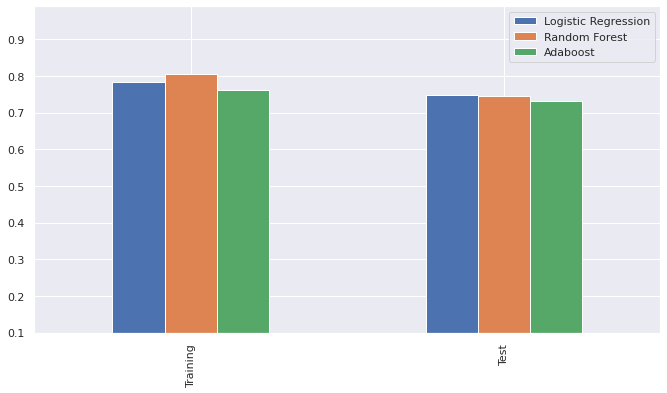

In [54]:
DTC = DecisionTreeClassifier(random_state = 42,criterion='gini', max_features = "auto", class_weight = "balanced",max_depth = 12)
ADC = AdaBoostClassifier(base_estimator=DTC)
cv_scores, test_scores = cv_classification(X_train, X_test, y_train, y_test,ADC,verbose=True)
plot_compare(Classification_results,'Adaboost',cv_scores,test_scores)
Final_Scores.loc[len(Final_Scores)+1] = ['Adaboost', cv_scores, test_scores]

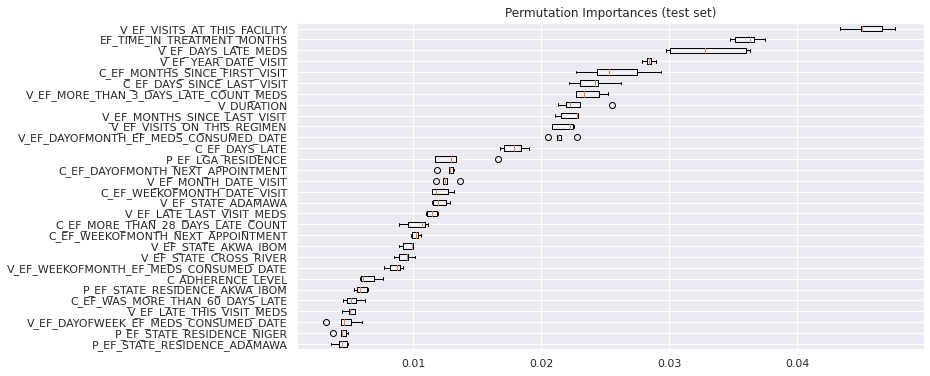

<Figure size 1440x1440 with 0 Axes>

In [55]:
from sklearn.inspection import permutation_importance
result = permutation_importance(ADC, X_test, y_test, n_repeats=5,
                                    random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

end = len(sorted_idx)
start = 0
if end >30:
    start=end-30

    fig, ax = plt.subplots()
    plt.figure(figsize=(20,20))
    ax.boxplot(result.importances[sorted_idx[start:end]].T,
               vert=False, labels=X_test.columns[sorted_idx[start:end]])
    ax.set_title("Permutation Importances (test set)")
    plt.show()

Train set target distribution:
 114814 0.661348110088361 
 58792 0.338651889911639 

Test set target distribution:
 34104 0.67 
 17179 0.33 


Metrics:
  f1: 0.599
  MCC: 0.399
  accuracy: 0.733
  specificity: 0.803
  precision: 0.603
  recal: 0.595
  roc_auc: 0.759
  GINI: 0.518
  PR_AUC: 0.494
  Brier_loss: 0.189

Classification report:
               precision    recall  f1-score   support

           0       0.80      0.80      0.80     34104
           1       0.60      0.59      0.60     17179

    accuracy                           0.73     51283
   macro avg       0.70      0.70      0.70     51283
weighted avg       0.73      0.73      0.73     51283



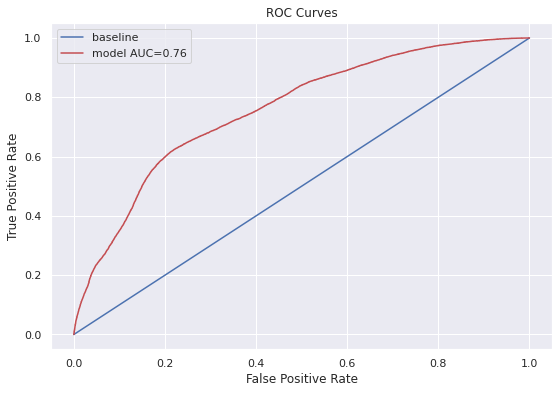

Confusion matrix:
[[27378  6726]
 [ 6961 10218]]


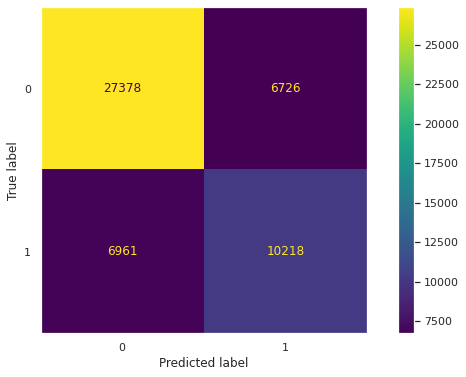

In [56]:
model_validation.evaluate_model(ADC, ADC.predict(X_test), ADC.predict_proba(X_test)[:,1], y_train, X_test, y_test, T_labels=None, normalise_conf_mtx=None)

Train set target distribution:
 114814 0.661348110088361 
 58792 0.338651889911639 

Test set target distribution:
 27670 0.66 
 13961 0.34 


Metrics:
  f1: 0.602
  MCC: 0.404
  accuracy: 0.735
  specificity: 0.805
  precision: 0.607
  recal: 0.598
  roc_auc: 0.761
  GINI: 0.522
  PR_AUC: 0.497
  Brier_loss: 0.188

Classification report:
               precision    recall  f1-score   support

           0       0.80      0.80      0.80     27670
           1       0.61      0.60      0.60     13961

    accuracy                           0.74     41631
   macro avg       0.70      0.70      0.70     41631
weighted avg       0.73      0.74      0.73     41631



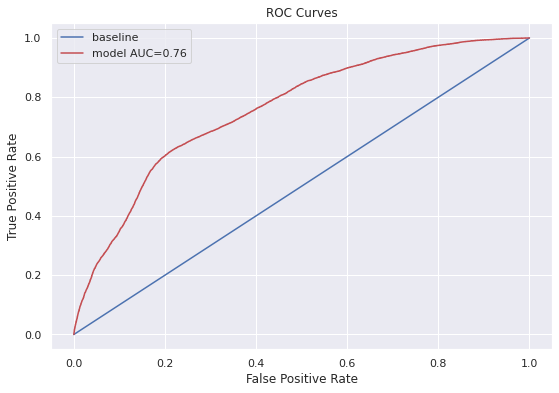

Confusion matrix:
[[22261  5409]
 [ 5618  8343]]


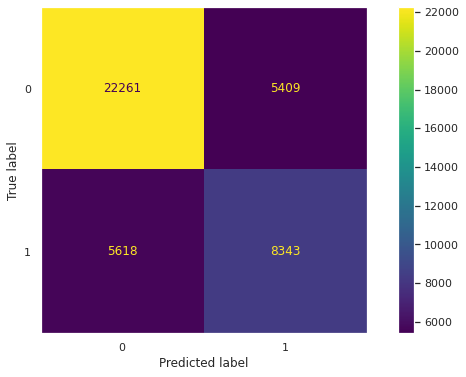

In [57]:
model_validation.evaluate_model(ADC, ADC.predict(X_val), ADC.predict_proba(X_val)[:,1], y_train, X_val, y_val, T_labels=None, normalise_conf_mtx=None)

### Voting Classifier Model

Avg roc_auc: 0.815 +/-0.002
roc_auc on test: 0.765


<Figure size 576x720 with 0 Axes>

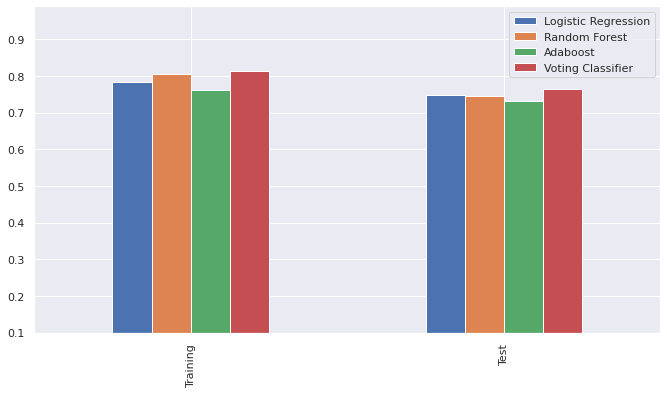

In [58]:
clf1 = LogisticRegression(random_state=42,solver='liblinear',C=10,penalty='l2')
clf2 = RandomForestClassifier(random_state=42,n_estimators=300,criterion='gini',max_features='auto',min_samples_split=4,max_depth=6,n_jobs=-1)
# clf3 = MultinomialNB()
from sklearn.neighbors import KNeighborsClassifier
clf3 = KNeighborsClassifier(n_jobs=-1)
Voting = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='soft',n_jobs=-1, weights=[1,3,2])
cv_scores, test_scores = cv_classification(X_train, X_test, y_train, y_test,Voting,verbose=True)
plot_compare(Classification_results,'Voting Classifier',cv_scores,test_scores)
Final_Scores.loc[len(Final_Scores)+1] = ['Voting Classifier', cv_scores, test_scores]

Train set target distribution:
 114814 0.661348110088361 
 58792 0.338651889911639 

Test set target distribution:
 34104 0.67 
 17179 0.33 


Metrics:
  f1: 0.579
  MCC: 0.441
  accuracy: 0.765
  specificity: 0.907
  precision: 0.723
  recal: 0.483
  roc_auc: 0.818
  GINI: 0.636
  PR_AUC: 0.522
  Brier_loss: 0.161

Classification report:
               precision    recall  f1-score   support

           0       0.78      0.91      0.84     34104
           1       0.72      0.48      0.58     17179

    accuracy                           0.76     51283
   macro avg       0.75      0.69      0.71     51283
weighted avg       0.76      0.76      0.75     51283



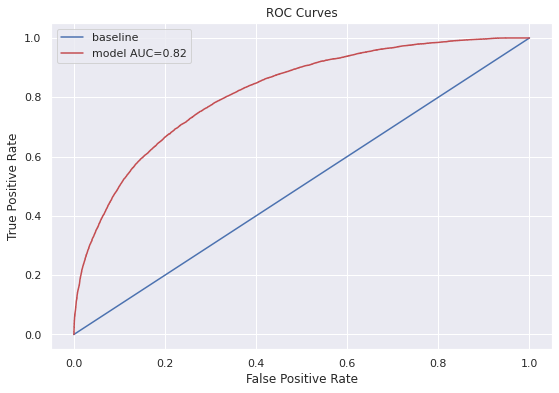

Confusion matrix:
[[30927  3177]
 [ 8889  8290]]


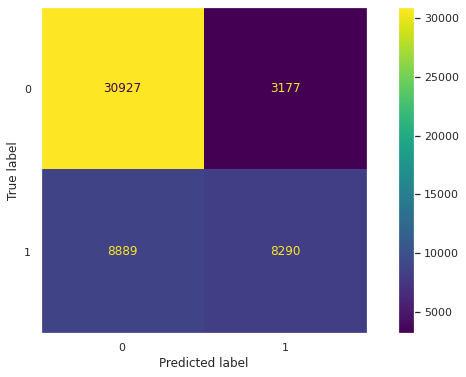

In [59]:
model_validation.evaluate_model(Voting, Voting.predict(X_test), Voting.predict_proba(X_test)[:,1], y_train, X_test, y_test, T_labels=None, normalise_conf_mtx=None)